# Sales Forecasting

*This project uses a lot of quantitative forecasting methods from basics to advanced that include Rolling Mean, Exponential Smoothing, and Machine Learning algorithms (both supervised and unsupervised learning models) to forecast daily sales (entire data and by product) and then evaluate the accuracy metrics (MAPE, RMSE,...) of each outcome.*

**Data source:** *https://www.kaggle.com/competitions/store-sales-time-series-forecasting/overview*

![My Image](https://towardsdatascience.com/wp-content/uploads/2020/09/18IOTiG6cY04XxbO73VeJlQ.png)

<a id="section-top"></a>
## Table of Contents

* [1. Import related libraries](#section-one)

* [2. Loading Dataset](#section-two)

* [3. Data Wrangling](#section-three)

* [4. Exploratory Data Analysis (EDA)](#section-four)

* [5. Rolling Mean](#section-five)

* [6. Exponential Smoothing](#section-six)
     - [6.1. Simple Exponential Smoothing](#section-six-one)
     - [6.2. Double Exponential Smoothing](#section-six-two)

* [7. Apply Machine Learning Techniques](#section-seven)
     - [7.1. Feature Engineering and Train - Test Split](#section-seven-one)
     - [7.2. Linear Regression](#section-seven-two)
     - [7.3. Random Forest Regression](#section-seven-three)
     - [7.4. Decision Tree Regression](#section-seven-four)
     - [7.5. Extreme Gradient Boosting](#section-seven-five)
     - [7.6. Extremely Randomized Trees](#section-seven-six)
     - [7.7. Adaptive Boosting Regression](#section-seven-seven) 
     - [7.8. Outcome Summarizing](#section-seven-eight) 
     - [7.9. K-means Clustering (estimate groups of products with similar seasonality factor)](#section-seven-nine)  

* [8. Multi-Product Forecasting with a Local Model](#section-eight)   


<a id="section-one"></a>
## 1. Import related libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from statsmodels.graphics.tsaplots import plot_acf ,plot_pacf
from sklearn.metrics import mean_squared_log_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from sklearn.cluster import KMeans 
from sklearn.metrics import mean_absolute_percentage_error

<a id="section-two"></a>
## 2. Loading Dataset

In [ ]:
stores_df = pd.read_csv('../dataset/store-sales-time-series-forecasting/train.csv', low_memory=False, parse_dates=True)
stores_df.head()

id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
1   1  2013-01-01          1   BABY CARE    0.0            0
2   2  2013-01-01          1      BEAUTY    0.0            0
3   3  2013-01-01          1   BEVERAGES    0.0            0
4   4  2013-01-01          1       BOOKS    0.0            0

In [841]:
print(stores_df['date'].min())
print(stores_df['date'].max())

2013-01-01
2017-08-15


In [842]:
stores_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


<a id="section-three"></a>
## 3. Data Wrangling

In [843]:
stores_df.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [844]:
stores_df.duplicated().sum()

0

In [845]:
stores_df['date'] = pd.to_datetime(stores_df['date'])
stores_df['date'] = pd.to_datetime(stores_df['date'].dt.strftime('%Y-%m-%d'))
stores_df = stores_df.sort_values(by='date')

In [846]:
stores_df['store_nbr'].nunique()

54

In [847]:
stores_df['family'].nunique()

33

In [848]:
sales_df = stores_df.drop(columns=['id', 'store_nbr', 'family', 'onpromotion'])

In [849]:
sales_df = sales_df.groupby('date', as_index = False)['sales'].sum()

<a id="section-four"></a>
## 4. Exploratory Data Analysis (EDA)

In [850]:
print(sales_df['date'].min())
print(sales_df['date'].max())

2013-01-01 00:00:00
2017-08-15 00:00:00


In [851]:
def sales_over_time(df, date, sales):
    df.rename(columns={sales: 'daily_sales'}, inplace=True)
    df['weekly_sales'] = df.groupby(pd.Grouper(key=date, freq='W'))['daily_sales'].transform('mean')
    df['monthly_sales'] = df.groupby(pd.Grouper(key=date, freq='ME'))['daily_sales'].transform('mean')
    df['yearly_sales'] = df.groupby(pd.Grouper(key=date, freq='YE'))['daily_sales'].transform('mean')
    return df

In [852]:
sales_eda = sales_over_time(sales_df.copy(), 'date', 'sales')
sales_eda.head()

date    daily_sales   weekly_sales  monthly_sales   yearly_sales
0 2013-01-01    2511.618999  368595.077913  333149.185062  385766.521757
1 2013-01-02  496092.417944  368595.077913  333149.185062  385766.521757
2 2013-01-03  361461.231124  368595.077913  333149.185062  385766.521757
3 2013-01-04  354459.677093  368595.077913  333149.185062  385766.521757
4 2013-01-05  477350.121229  368595.077913  333149.185062  385766.521757

In [853]:
def plot_sales_over_time(df, date_col='date'):
    plt.figure(figsize=(20, 5))
    plt.plot(df[date_col], df['daily_sales'], label='Daily Sales', color = '#999999', linewidth= 1)
    plt.plot(df[date_col], df['weekly_sales'], label='Weekly Sales(Average)', color = 'orange', linewidth= 1)
    plt.plot(df[date_col], df['monthly_sales'], label='Monthly Sales(Average)', color = 'green', linewidth= 1)
    plt.plot(df[date_col], df['yearly_sales'], label='Yearly Sales(Average)', color = 'red', linewidth= 1)
    
    plt.xlabel('Time Period')
    plt.ylabel('Quantity')
    plt.title('Daily, Weekly, Monthly and Yearly Sales')
    plt.legend()
    plt.xticks(rotation=45)
    plt.xlim((sales_df['date'].min(),sales_df['date'].max()))
    plt.show()

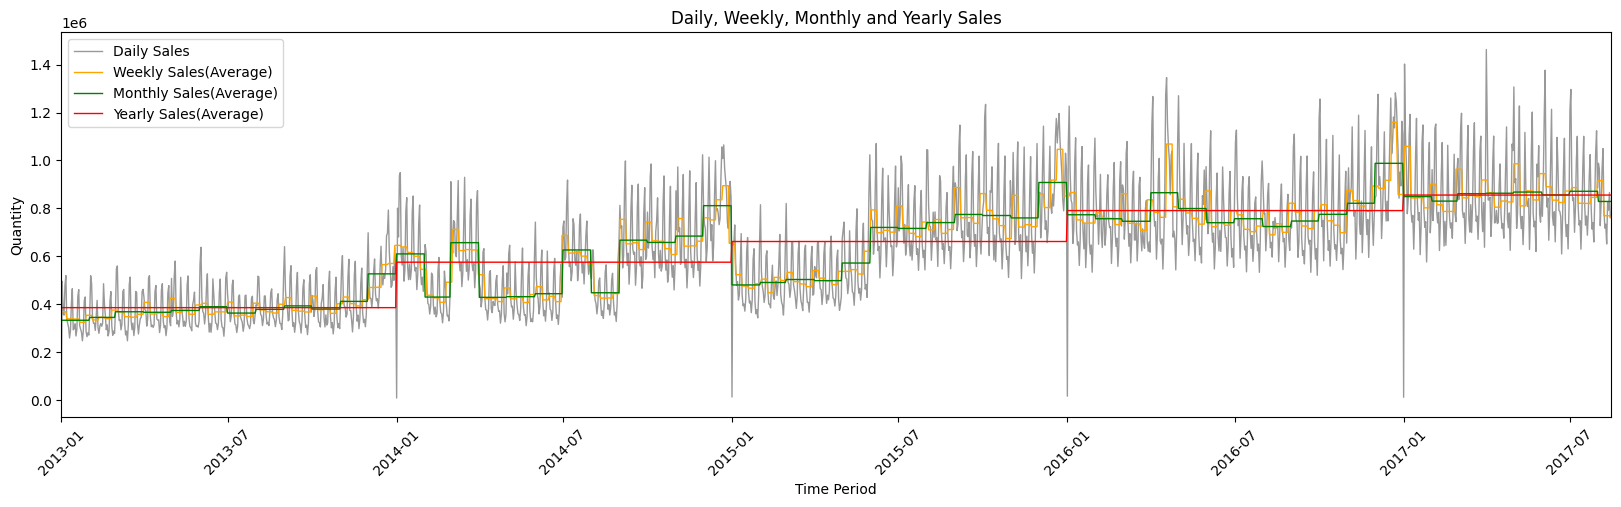

In [854]:
plot_sales_over_time(sales_eda)

In [855]:
# Monthly total sales per year
def monthly_sales_per_year(df, sales, date):
    df['Year'] = df[date].dt.year 
    df = df.pivot(columns= 'Year', values= sales, index= date).reset_index(drop= False)
    df['Month'] = df[date].dt.month
    df.drop(columns = [ 'date'], inplace= True)
    df = df.groupby('Month', as_index= True).sum()
    df.replace({0: np.nan}, inplace=True)
    return df

In [856]:
sales_monthly = monthly_sales_per_year(sales_df.copy(), 'sales', 'date')
sales_monthly.head()

Year           2013          2014          2015          2016          2017
Month                                                                      
1      1.032762e+07  1.891164e+07  1.489692e+07  2.397780e+07  2.632816e+07
2      9.658960e+06  1.203835e+07  1.374240e+07  2.194741e+07  2.325011e+07
3      1.142850e+07  2.036558e+07  1.559861e+07  2.313178e+07  2.670402e+07
4      1.099346e+07  1.286125e+07  1.495507e+07  2.596303e+07  2.589531e+07
5      1.159770e+07  1.337979e+07  1.773037e+07  2.477943e+07  2.691185e+07

In [857]:
def plot_sales_monthly(df):
    plt.figure(figsize=(10, 5))

    for year in df.columns:
        plt.plot(df.index, df[year], label=f'{year}', linewidth=1)
    
    plt.xlabel('Month')
    plt.ylabel('Sales Total')
    plt.title('Monthly total sales per year')
    plt.legend()
    plt.xlim((df.index.min(),df.index.max()))
    plt.show()

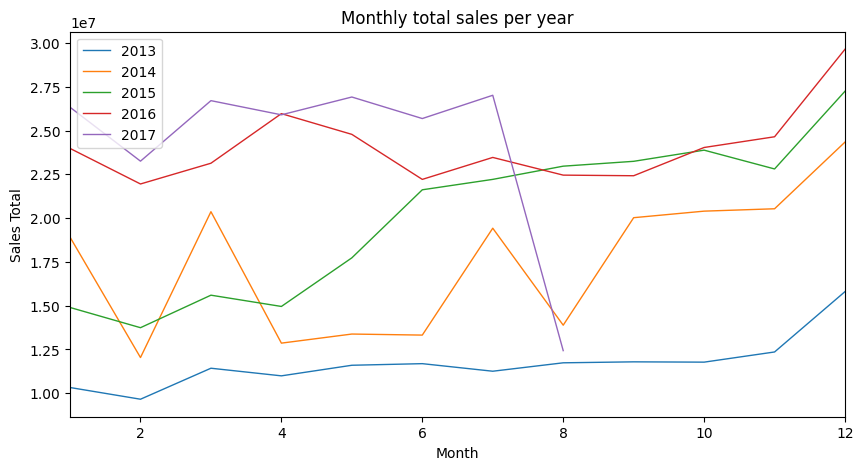

In [858]:
plot_sales_monthly(sales_monthly)

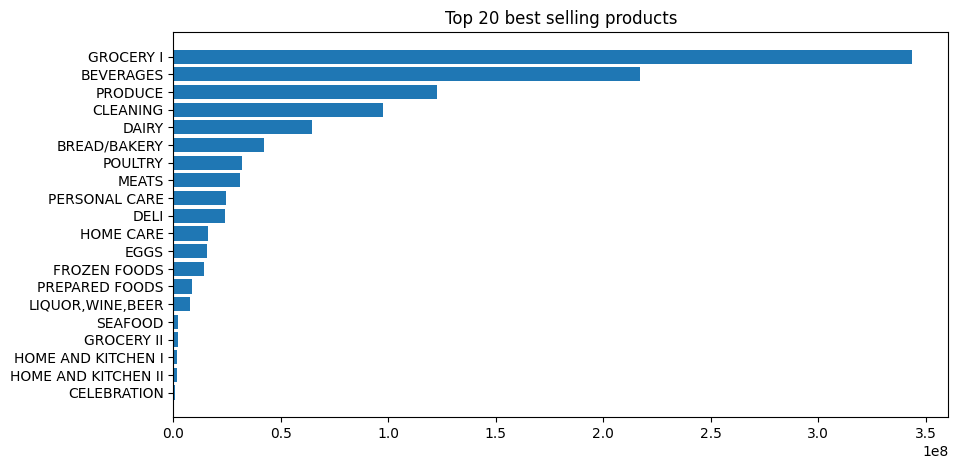

In [859]:
plt.figure(figsize=(10,5))

product= stores_df[['family', 'sales']].groupby('family', as_index= False)['sales'].sum().sort_values(by='sales', ascending=True)
product.rename(columns= {'sales':'Total Sales'}, inplace= True)
plt.barh(product['family'].tail(20), product['Total Sales'].tail(20))
plt.title('Top 20 best selling products')
    
plt.show()

<a id="section-five"></a>
## 5. Rolling Mean

In [860]:
def calculate_rolling_mean(df, date, daily_sales):
    for window in range(5, 10):
        rolling_mean_col = f'rolling_mean_{window}'
        df[rolling_mean_col] = df[daily_sales].rolling(window=window).mean()
    return df

In [861]:
def plot_rolling_sales(df, date, sales):
    plt.figure(figsize=(20, 5))
    plt.plot(df[date], df[sales], label=sales, color='#999999', linewidth=1)
    colors = ['orange', 'green', 'red', 'purple', 'brown']
    for i, window in enumerate(range(5, 10)):
        plt.plot(df[date], df[f'rolling_mean_{window}'], label=f'Rolling Mean ({window} periods)', color=colors[i], linewidth=1, linestyle= '--')
    
    plt.xlabel('Time Period')
    plt.ylabel('Sales')
    plt.title(f'{sales} Rolling Mean')
    plt.legend()
    plt.xticks(rotation=90)
    plt.xlim((df[date].min(), df[date].max()))
    plt.show()

In [862]:
daily_sales_df = sales_df.groupby('date', as_index=False)['sales'].sum().sort_values(by='date').rename(columns={'sales': 'Daily_Sales'})
daily_rolling_df = calculate_rolling_mean(daily_sales_df, 'date', 'Daily_Sales')
daily_rolling_df.head()

date    Daily_Sales  rolling_mean_5  rolling_mean_6  rolling_mean_7  \
0 2013-01-01    2511.618999             NaN             NaN             NaN   
1 2013-01-02  496092.417944             NaN             NaN             NaN   
2 2013-01-03  361461.231124             NaN             NaN             NaN   
3 2013-01-04  354459.677093             NaN             NaN             NaN   
4 2013-01-05  477350.121229   338375.013278             NaN             NaN   

   rolling_mean_8  rolling_mean_9  
0             NaN             NaN  
1             NaN             NaN  
2             NaN             NaN  
3             NaN             NaN  
4             NaN             NaN

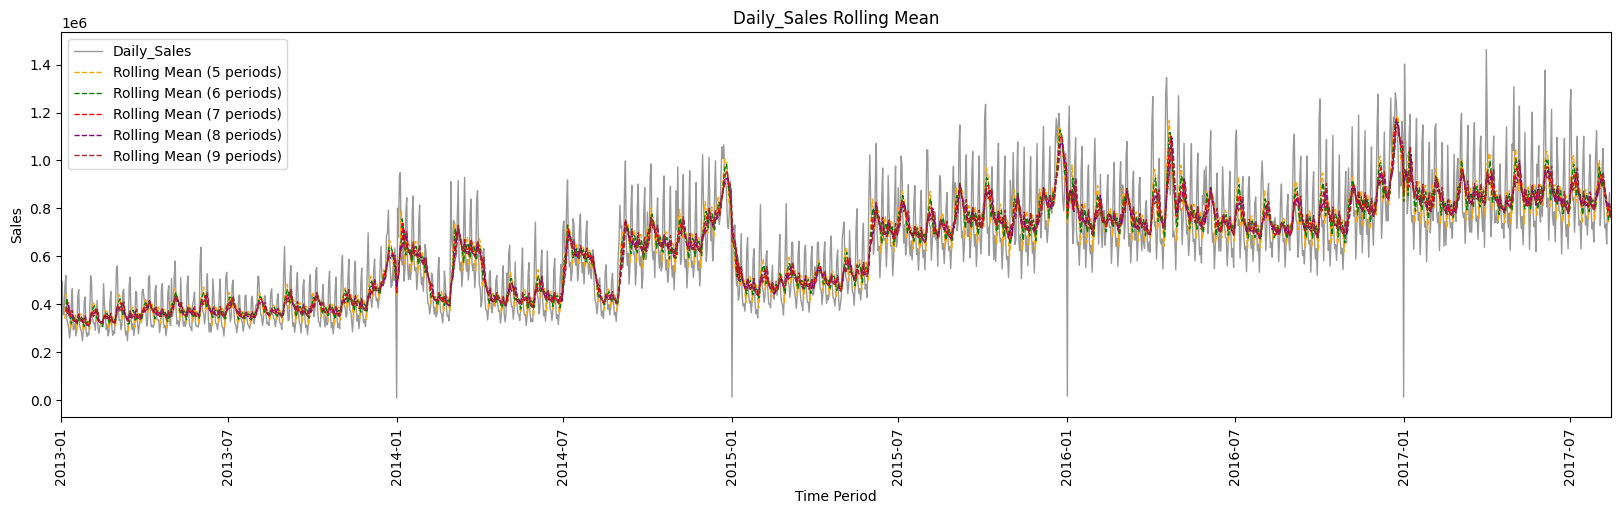

In [863]:
plot_rolling_sales(daily_rolling_df, 'date', 'Daily_Sales')

<a id="section-six"></a>
## 6. Exponential Smoothing

<a id="section-six-one"></a>
### 6.1. Simple Exponential Smoothing

In [864]:
def simple_exp_smooth(df, sales, alpha):
    alpha = float(alpha)  # Convert alpha to float
    df['forecast'] = 0.0
    df.at[0, 'forecast'] = df.at[0, sales]
    for k in range(1, len(df)):
        df.at[k, 'forecast'] = alpha * df.at[k-1, sales] + (1 - alpha) * df.at[k-1, 'forecast']
    
    return df

In [865]:
forecast_simp = simple_exp_smooth(sales_df.copy(), 'sales', 0.3)
forecast_simp.head()

date          sales       forecast
0 2013-01-01    2511.618999    2511.618999
1 2013-01-02  496092.417944    2511.618999
2 2013-01-03  361461.231124  150585.858682
3 2013-01-04  354459.677093  213848.470415
4 2013-01-05  477350.121229  256031.832418

<Axes: title={'center': 'Simple Exponential Smoothing (alpha = 0.3)'}, xlabel='date'>

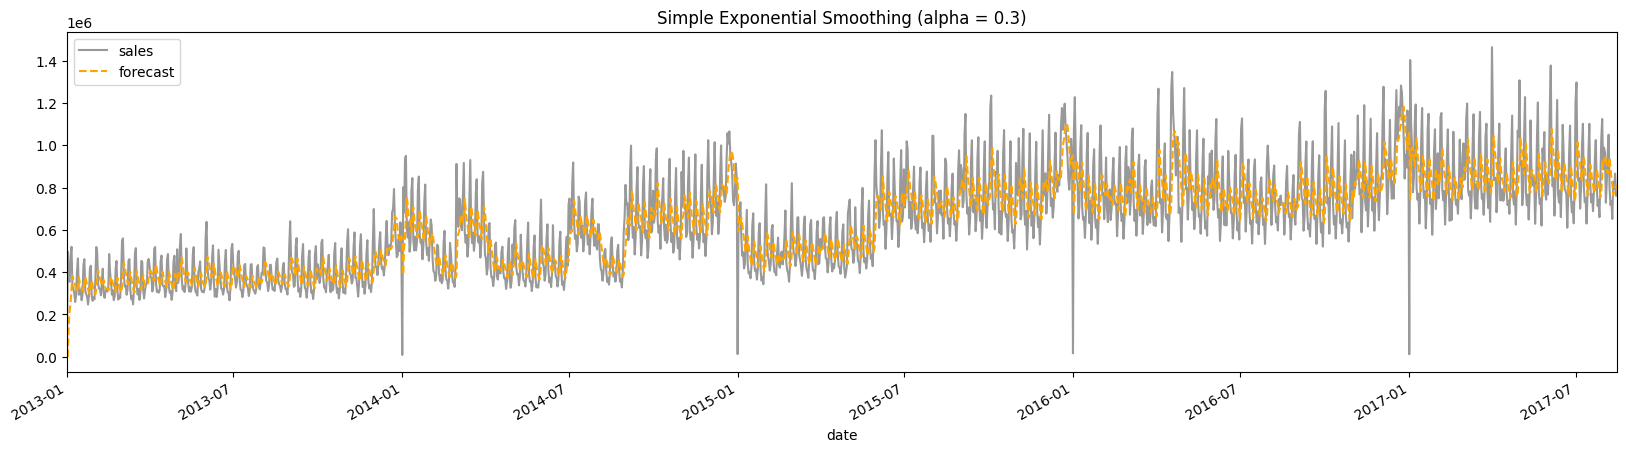

In [866]:
forecast_simp.plot(kind='line', x='date', y=['sales', 'forecast'], figsize=(20,5), 
                   style=['-','--'], 
                   xlim=(forecast_simp['date'].min(),forecast_simp['date'].max()), 
                   color=('#999999', 'orange'),
                   title = 'Simple Exponential Smoothing (alpha = 0.3)')

<a id="section-six-two"></a>
### 6.2. Double Exponential Smoothing

In [867]:
def double_exp_smooth(df, sales, alpha, beta):
    alpha = float(alpha)  # Convert alpha to float
    beta = float(beta)
    
    df['level'] = 0.0
    df['trend'] = 0.0
    df['forecast'] = np.NaN
    
    df.at[0, 'level'] = df.at[0, sales]
    df.at[0, 'trend'] = df.at[1, sales] - df.at[0, sales]
    df.at[1, 'forecast'] = df.at[0, 'level'] + df.at[0, 'trend']
    
    for k in range(2, len(df)):
        df.at[k-1 , 'level'] = alpha * df.at[k-1, sales] + (1 - alpha) * (df.at[k-2, 'level'] + df.at[k-2, 'trend'])
        df.at[k-1 , 'trend'] = beta * (df.at[k-1 , 'level'] - df.at[k-2, 'level']) + (1 - beta) * df.at[k-2, 'trend']
        df.at[k, 'forecast'] = df.at[k-1, 'level'] + df.at[k-1, 'trend']
    
    return df

In [868]:
forecast_dou = double_exp_smooth(sales_df.copy(), 'sales', 0.3, 0.4)
forecast_dou.head()

date          sales         level          trend      forecast
0 2013-01-01    2511.618999  2.511619e+03  493580.798945           NaN
1 2013-01-02  496092.417944  4.960924e+05  493580.798945  4.960924e+05
2 2013-01-03  361461.231124  8.012096e+05  418195.360653  9.896732e+05
3 2013-01-04  354459.677093  9.599214e+05  314401.924087  1.219405e+06
4 2013-01-05  477350.121229  1.035231e+06  218765.140896  1.274323e+06

<Axes: title={'center': 'Double Exponential Smoothing (alpha = 0.3, beta = 0.4)'}, xlabel='date'>

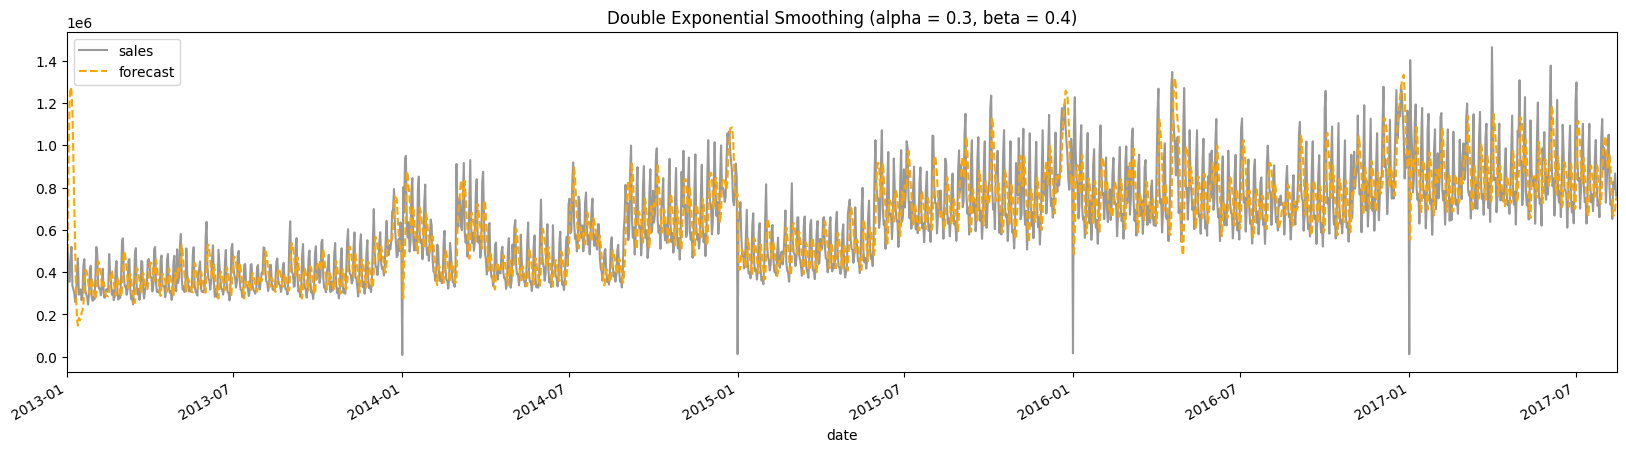

In [869]:
forecast_dou.plot(kind='line', x='date', y=['sales', 'forecast'], figsize=(20,5), 
                  style=['-','--'], 
                  xlim=(forecast_dou['date'].min(),forecast_dou['date'].max()), 
                  color=('#999999', 'orange'),
                  title = 'Double Exponential Smoothing (alpha = 0.3, beta = 0.4)')

<a id="section-seven"></a>
## 7. Apply Machine Learning Techniques

<a id="section-seven-one"></a>
### 7.1. Feature Engineering and Train - Test Split

*Timeseries data almost always have information that is shared between timepoints*

*Information in the past can help predict what happens in the future*

*Often the features best-suited to predict a timeseries are previous values of the same timeseries.*

In [870]:
def decompose_date_sales(df, date, quantity):
    # Time paterns
    df['Month'] = df[date].dt.month
    df['Year'] = df[date].dt.year  
    df['Day'] = df[date].dt.day
    df['Day_of_week'] = df[date].dt.weekday
    df['Week_of_year'] = pd.to_datetime(sales_df[date]).dt.strftime('%U').astype('int32')
    df['Day_of_year'] = df[date].dt.dayofyear
    df['Weekend'] = df['Day_of_week'].apply(lambda x: 1 if x > 5 else 0)
    df['Quarter'] = df[date].dt.quarter
    # Sales paterns
    df['Sales_1_day_ago'] = df[quantity].shift(1)
    df['Sales_7_days_ago'] = df[quantity].shift(7)
    df['Rolling_Mean_14_day_sales'] = df[quantity].rolling(window=14).mean().reset_index(drop=True)
    df['Rolling_Mean_28_day_sales'] = df[quantity].rolling(window=28).mean().reset_index(drop=True)
    return df

In [871]:
sales_df = decompose_date_sales(sales_df, 'date', 'sales')
sales_df.head()

date          sales  Month  Year  Day  Day_of_week  Week_of_year  \
0 2013-01-01    2511.618999      1  2013    1            1             0   
1 2013-01-02  496092.417944      1  2013    2            2             0   
2 2013-01-03  361461.231124      1  2013    3            3             0   
3 2013-01-04  354459.677093      1  2013    4            4             0   
4 2013-01-05  477350.121229      1  2013    5            5             0   

   Day_of_year  Weekend  Quarter  Sales_1_day_ago  Sales_7_days_ago  \
0            1        0        1              NaN               NaN   
1            2        0        1      2511.618999               NaN   
2            3        0        1    496092.417944               NaN   
3            4        0        1    361461.231124               NaN   
4            5        0        1    354459.677093               NaN   

   Rolling_Mean_14_day_sales  Rolling_Mean_28_day_sales  
0                        NaN                        NaN  
1                        NaN                        NaN  
2                        NaN                        NaN  
3                        NaN                        NaN  
4                        NaN                        NaN

In [872]:
# One-Hot Encoding
features = ['Weekend', 'Month', 'Quarter', 'Day_of_week']

def encode_and_bind(df, features):
    dummies = pd.get_dummies(df[[features]], columns=[features], dtype=int)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop([features], axis=1)
    return df 

for feature in features:
    sales_df = encode_and_bind(sales_df, feature)

In [873]:
sales_df.columns

Index(['date', 'sales', 'Year', 'Day', 'Week_of_year', 'Day_of_year',
       'Sales_1_day_ago', 'Sales_7_days_ago', 'Rolling_Mean_14_day_sales',
       'Rolling_Mean_28_day_sales', 'Weekend_0', 'Weekend_1', 'Month_1',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7',
       'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12', 'Quarter_1',
       'Quarter_2', 'Quarter_3', 'Quarter_4', 'Day_of_week_0', 'Day_of_week_1',
       'Day_of_week_2', 'Day_of_week_3', 'Day_of_week_4', 'Day_of_week_5',
       'Day_of_week_6'],
      dtype='object')

<Axes: >

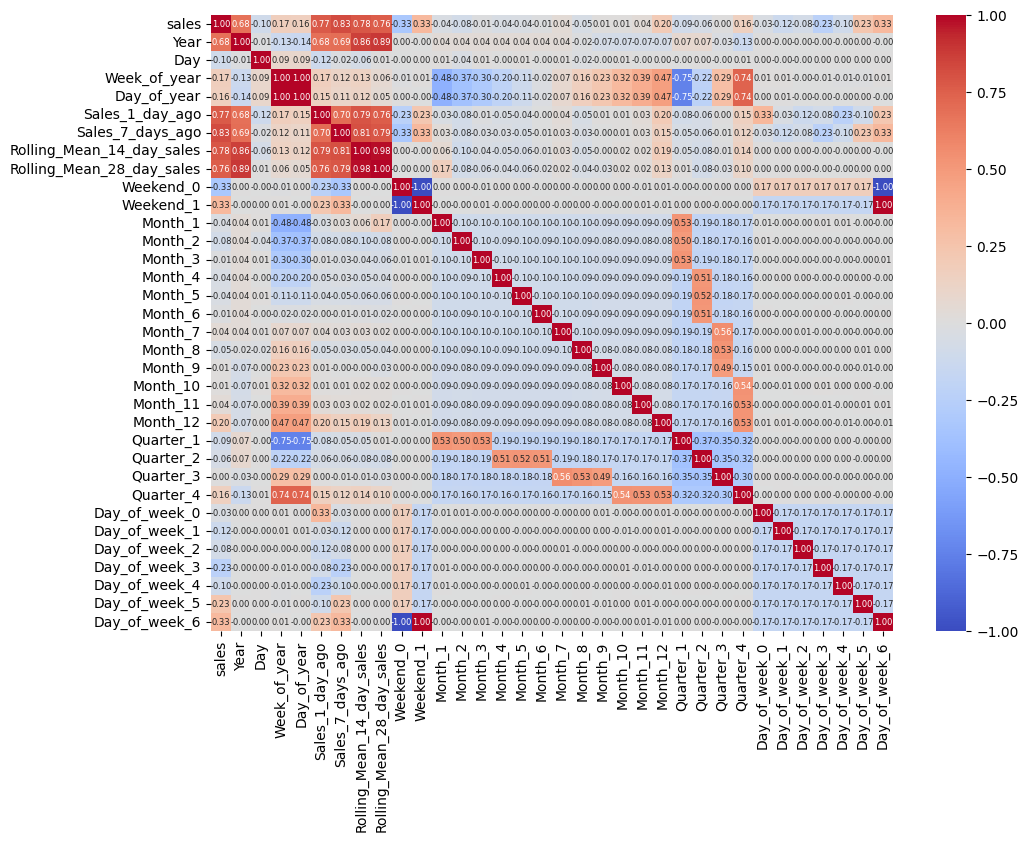

In [874]:
# Drop non-numeric columns
numeric_sales_df = sales_df.select_dtypes(include=[np.number])

# Calculate the correlation matrix
corr = numeric_sales_df.corr()

# Plot the heatmap
plt.figure(figsize=(11, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={'size': 6})

In [875]:
sales_df.dropna(axis=0,inplace= True)
sales_df.head()

date          sales  Year  Day  Week_of_year  Day_of_year  \
27 2013-01-28  285460.169953  2013   28             4           28   
28 2013-01-29  264488.818077  2013   29             4           29   
29 2013-01-30  281061.127052  2013   30             4           30   
30 2013-01-31  271254.217996  2013   31             4           31   
31 2013-02-01  369402.055266  2013    1             4           32   

    Sales_1_day_ago  Sales_7_days_ago  Rolling_Mean_14_day_sales  \
27    430411.991233     311211.265950              330877.422002   
28    285460.169953     296214.728983              328403.084010   
29    264488.818077     283258.453032              325739.742089   
30    281061.127052     247245.690995              326008.006519   
31    271254.217996     290022.771930              331241.664036   

    Rolling_Mean_28_day_sales  ...  Quarter_2  Quarter_3  Quarter_4  \
27              339672.163349  ...          0          0          0   
28              349028.491888  ...          0          0          0   
29              341348.802928  ...          0          0          0   
30              338127.123887  ...          0          0          0   
31              338660.780251  ...          0          0          0   

    Day_of_week_0  Day_of_week_1  Day_of_week_2  Day_of_week_3  Day_of_week_4  \
27              1              0              0              0              0   
28              0              1              0              0              0   
29              0              0              1              0              0   
30              0              0              0              1              0   
31              0              0              0              0              1   

    Day_of_week_5  Day_of_week_6  
27              0              0  
28              0              0  
29              0              0  
30              0              0  
31              0              0  

[5 rows x 35 columns]

In [876]:
def train_test_data_split (df):
    X = df.drop(columns= ['date', 'sales'])
    Y = df[['sales']]
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False) 
    return X_train, X_test, Y_train, Y_test   

In [877]:
X_train, X_test, Y_train, Y_test = train_test_data_split(sales_df)

In [878]:
print('X_train.size=', X_train.shape, 'Y_train.size=', Y_train.shape)
print('X_test.size=', X_test.shape, 'Y_test.size=', Y_test.shape)

X_train.size= (1325, 33) Y_train.size= (1325, 1)
X_test.size= (332, 33) Y_test.size= (332, 1)


<a id="section-seven-two"></a>
### 7.2. Linear Regression

In [879]:
def train_regression_model(X_train, Y_train):
    model = LinearRegression()
    model.fit(X_train, Y_train)
    
    result = Y_train.copy()
    
    result['Predicted_Sales'] = model.predict(X_train)
    result['date'] = sales_df['date']
    result['date'].reset_index(drop=True, inplace=True)
    result['Residuals'] = result['sales'] - result['Predicted_Sales']
    
    print('R-squared:', r2_score(result['sales'], result['Predicted_Sales']))  
    
    # View results
    plt.figure(figsize=(20,8))
    
    plt.subplot(1,2,1)
    plt.scatter(result['sales'], result['Predicted_Sales'])
    plt.title("Predicted vs. Actual Sales")
    plt.xlabel("Actual Sales", labelpad = 30)
    plt.ylabel("Predicted", labelpad = 30)
    
    plt.subplot(1,2,2)
    plt.hist(result['Residuals'], bins= 100)
    plt.title("Residuals Distribution")
    plt.xlabel("Residuals", labelpad = 30)
    plt.ylabel("Number of Days", labelpad = 30)
    
    plt.show()
    
    return result, model

R-squared: 0.8647648947120545


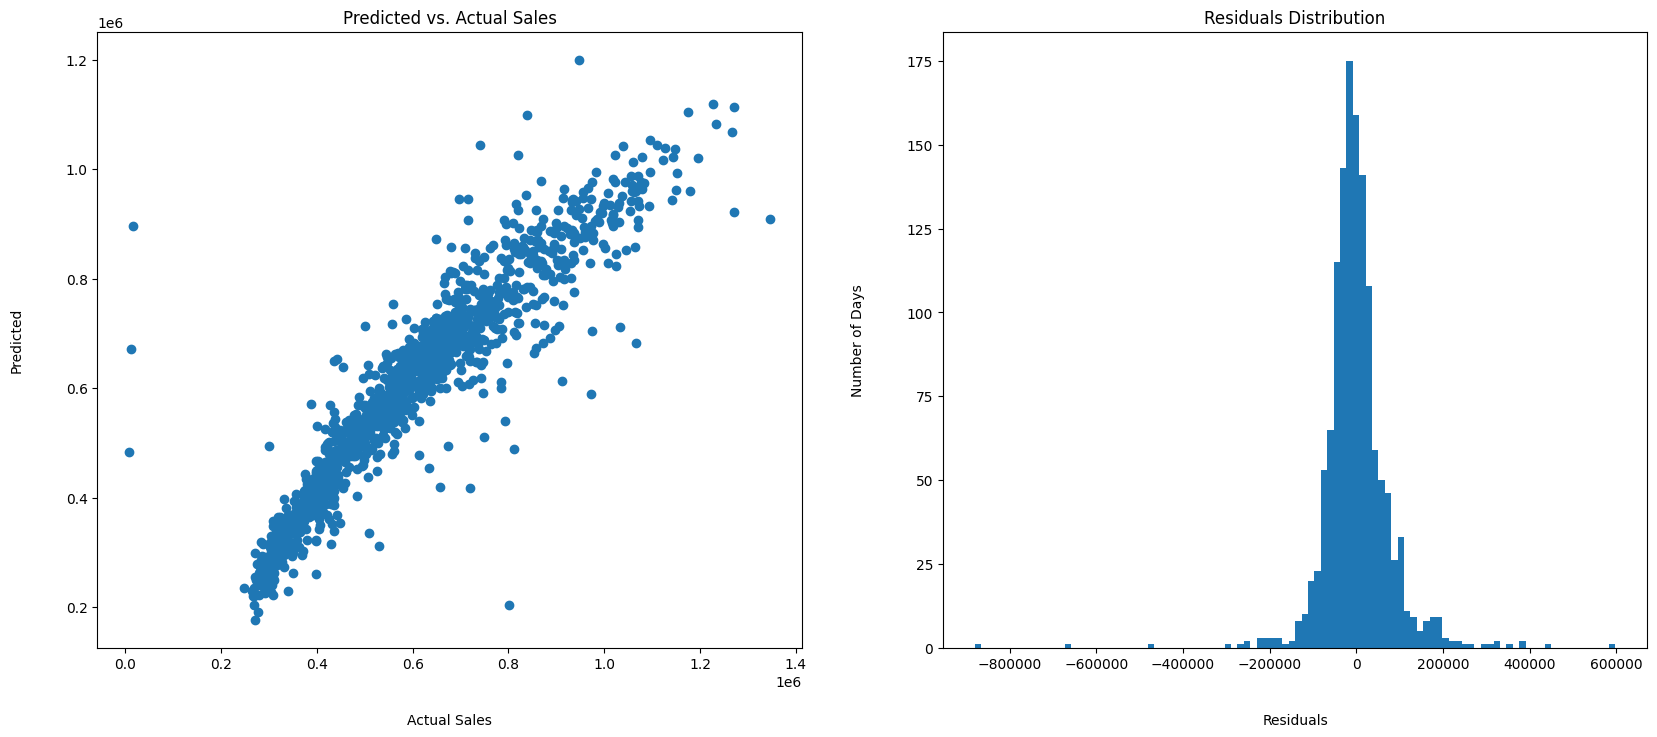

sales  Predicted_Sales       date     Residuals
27  285460.169953    255983.483110 2013-01-28  29476.686843
28  264488.818077    229749.741891 2013-01-29  34739.076185
29  281061.127052    256583.911401 2013-01-30  24477.215651
30  271254.217996    177435.613990 2013-01-31  93818.604006
31  369402.055266    295643.921004 2013-02-01  73758.134262

In [880]:
lr_result, model = train_regression_model(X_train, Y_train)
lr_result.head()

In [881]:
def performance_metrics(df):
    df['Residuals'] = np.abs(df['sales'] - df['Predicted_Sales'])
    df['Square_of_Error'] = df['Residuals']**2
    df['Absolute_Error'] = df['Residuals']/df['sales']
    mad = np.mean(np.abs(df['Residuals']))
    mse = df['Square_of_Error'].mean()
    rmse = np.sqrt(mse)
    mape = df['Absolute_Error'].mean()*100
    rmsle = np.sqrt(mean_squared_log_error(df['sales'], df['Predicted_Sales']))
    return mad, mse, rmse, mape, rmsle

In [882]:
def plot(df, x_test, y_test):
    y_test['date'] = sales_df['date']
    y_test['Predicted_Sales'] = model.predict(x_test)
    
    plt.figure(figsize=(20, 5))
    plt.plot(df['date'], df['sales'], label='Train_Actual', color = '#999999', linewidth= 1)
    plt.plot(df['date'], df['Predicted_Sales'], label='Train_Predicted', color = 'ORANGE', linewidth= 1, linestyle= '--')
    plt.plot(y_test['date'], y_test['sales'], label='Test_Actual', color = '#999999', linewidth= 1)
    plt.plot(y_test['date'], y_test['Predicted_Sales'], label='Test_Predicted', color = 'BLUE', linewidth= 1, linestyle= '--')
    
    plt.xlabel('Time Period')
    plt.ylabel('Sales')
    plt.title('Train - Test Sales Forecasting')
    plt.axvline(y_test['date'].min(), color = 'black', linestyle = '--', linewidth = 1)
    plt.legend()
    plt.xticks(rotation=45)
    plt.xlim((df['date'].min(),y_test['date'].max()))
    plt.show()

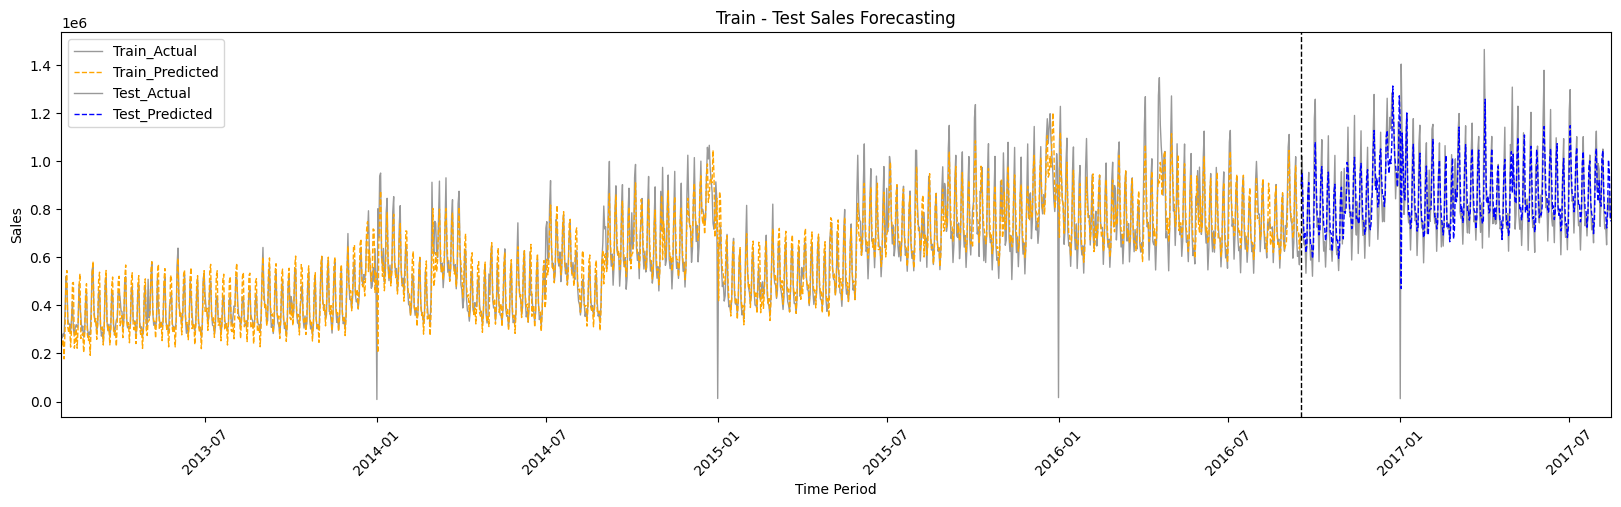

In [883]:
plot(lr_result, X_test, Y_test)

In [884]:
#Trainset
mad, mse, rmse, mape, rmsle = performance_metrics(lr_result)
print('MAD=', mad, 'MSE=', mse, 'RMSE=', rmse, 'MAPE=', mape, 'RMSLE=', rmsle)

MAD= 49602.25961442335 MSE= 6157613835.524906 RMSE= 78470.46473371307 MAPE= 20.162061784081008 RMSLE= 0.2230261288006985


In [885]:
#Testset
mad, mse, rmse, mape, rmsle = performance_metrics(Y_test)
print('MAD=', mad, 'MSE=', mse, 'RMSE=', rmse, 'MAPE=', mape, 'RMSLE=', rmsle)

MAD= 76547.13092602212 MSE= 15068657715.312473 RMSE= 122754.4610811048 MAPE= 36.8046029186795 RMSLE= 0.2769991132625471


<a id="section-seven-three"></a>
### 7.3. Random Forest Regression

In [886]:
def train_random_forest_model(X_train, Y_train):
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, Y_train)
    
    result = Y_train.copy()
    
    result['Predicted_Sales'] = model.predict(X_train)
    result['date'] = sales_df['date']
    result['date'].reset_index(drop=True, inplace=True)
       
    print('R-squared:', r2_score(result['sales'], result['Predicted_Sales']))  
    
    # Feature importance visualization
    features = X_train.columns
    importances = model.feature_importances_
    indices = np.argsort(importances)

    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()
    
    return result, model

c:\Users\Zenbook\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


R-squared: 0.9824429118796473


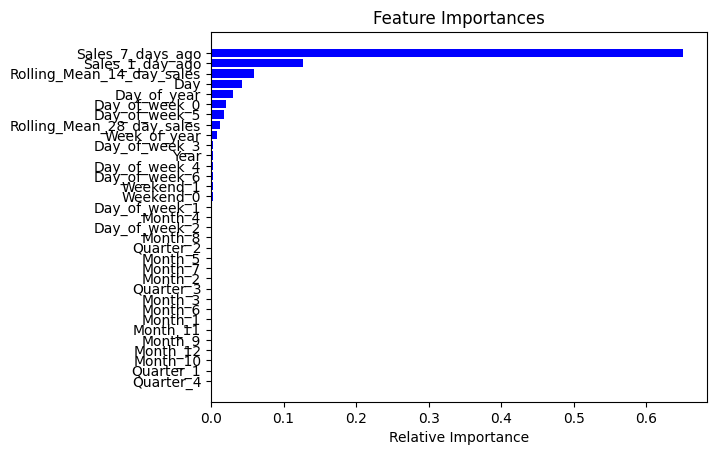

sales  Predicted_Sales       date
27  285460.169953    298880.814300 2013-01-28
28  264488.818077    274178.624328 2013-01-29
29  281061.127052    284155.822124 2013-01-30
30  271254.217996    273340.824913 2013-01-31
31  369402.055266    379649.506832 2013-02-01

In [887]:
rdf_result, model = train_random_forest_model(X_train, Y_train)
rdf_result.head()

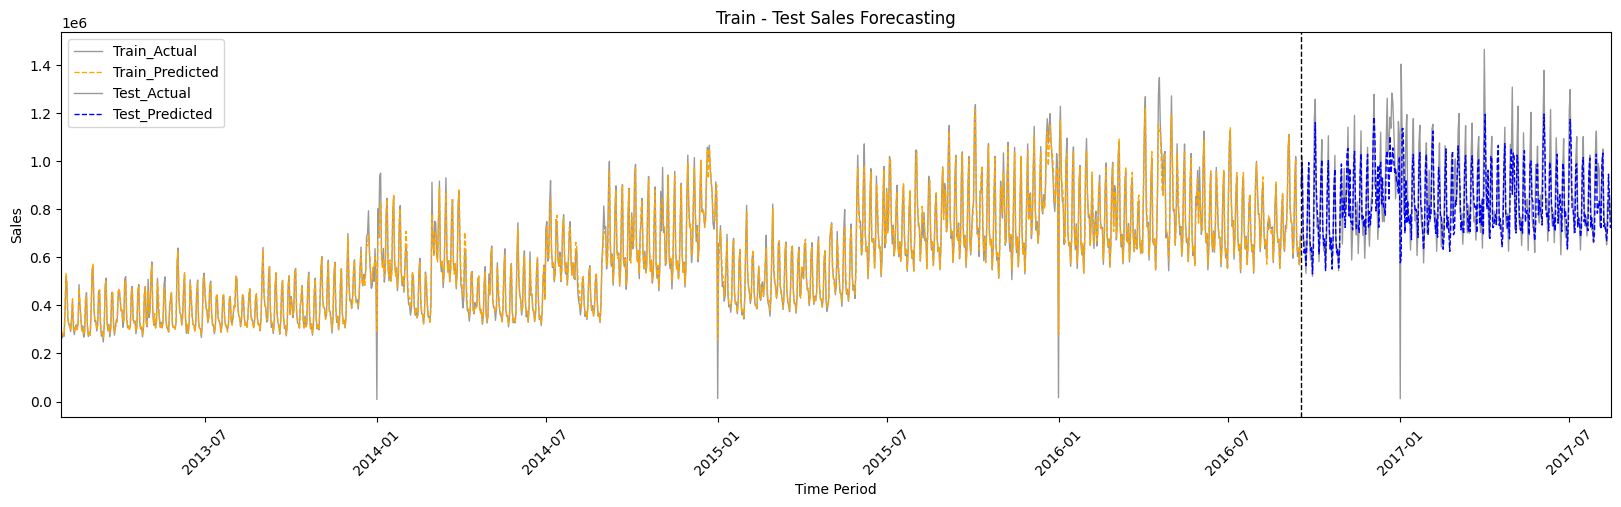

In [888]:
plot(rdf_result, X_test, Y_test)

In [889]:
#Trainset
mad, mse, rmse, mape, rmsle = performance_metrics(rdf_result)
print('MAD=', mad, 'MSE=', mse, 'RMSE=', rmse, 'MAPE=', mape, 'RMSLE=', rmsle)

MAD= 15793.692753255656 MSE= 799420893.6446226 RMSE= 28274.032143375352 MAPE= 7.596751784813365 RMSLE= 0.1534623974669717


In [890]:
#Testset
mad, mse, rmse, mape, rmsle = performance_metrics(Y_test)
print('MAD=', mad, 'MSE=', mse, 'RMSE=', rmse, 'MAPE=', mape, 'RMSLE=', rmsle)

MAD= 82562.67677620337 MSE= 13906655939.908827 RMSE= 117926.48531991796 MAPE= 23.25900820728493 RMSLE= 0.24686321689330887


<a id="section-seven-four"></a>
### 7.4. Decision Tree Regression

In [891]:
def train_decision_tree_model(X_train, Y_train):
    model = DecisionTreeRegressor(max_depth=5, min_samples_split=15, min_samples_leaf=5)
    model.fit(X_train, Y_train)
    
    result = Y_train.copy()
    
    result['Predicted_Sales'] = model.predict(X_train)
    result['date'] = sales_df['date']
    result['date'].reset_index(drop=True, inplace=True) 
       
    print('R-squared:', r2_score(result['sales'], result['Predicted_Sales']))  
    
    # Feature importance visualization
    features = X_train.columns
    importances = model.feature_importances_
    indices = np.argsort(importances)

    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()
    
    return result, model

R-squared: 0.8557590010533476


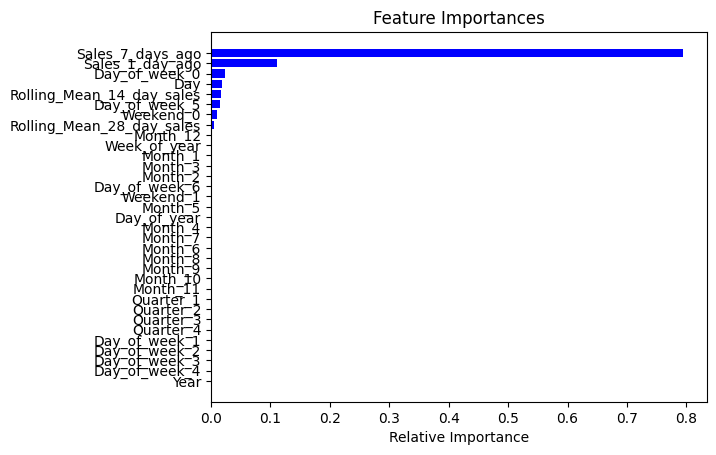

sales  Predicted_Sales       date
27  285460.169953    368078.753841 2013-01-28
28  264488.818077    323197.949380 2013-01-29
29  281061.127052    323197.949380 2013-01-30
30  271254.217996    323197.949380 2013-01-31
31  369402.055266    407473.186834 2013-02-01

In [892]:
dtr_result, model = train_decision_tree_model(X_train, Y_train)
dtr_result.head()

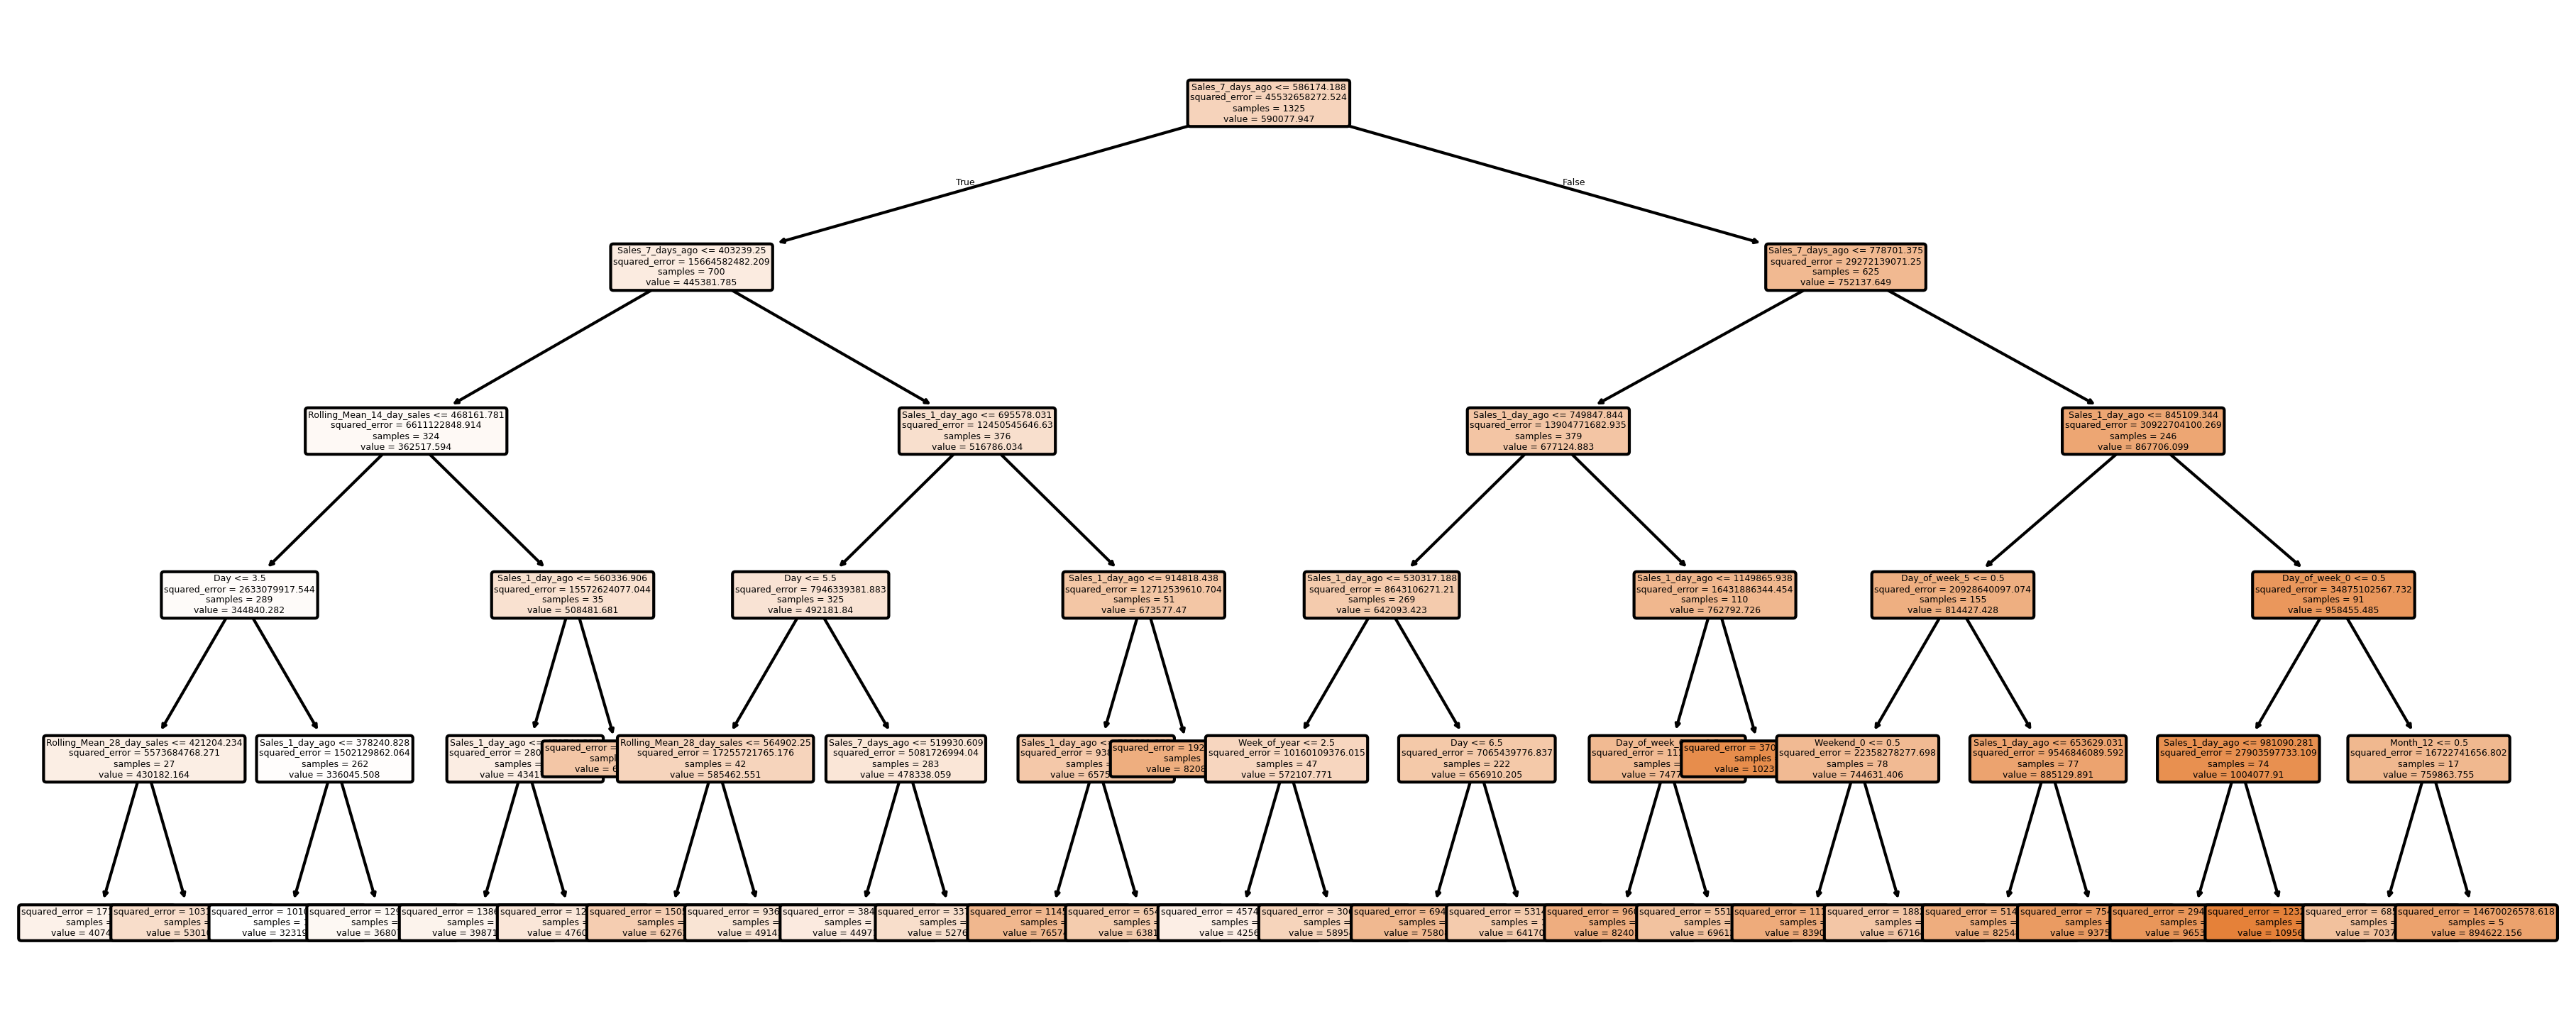

In [893]:
from sklearn.tree import plot_tree

fig = plt.figure(figsize=(15,6), dpi=300)
ax = fig.gca()
plot_tree(model, fontsize=3, feature_names=X_train.columns, rounded=True, filled=True, ax=ax)
plt.show()

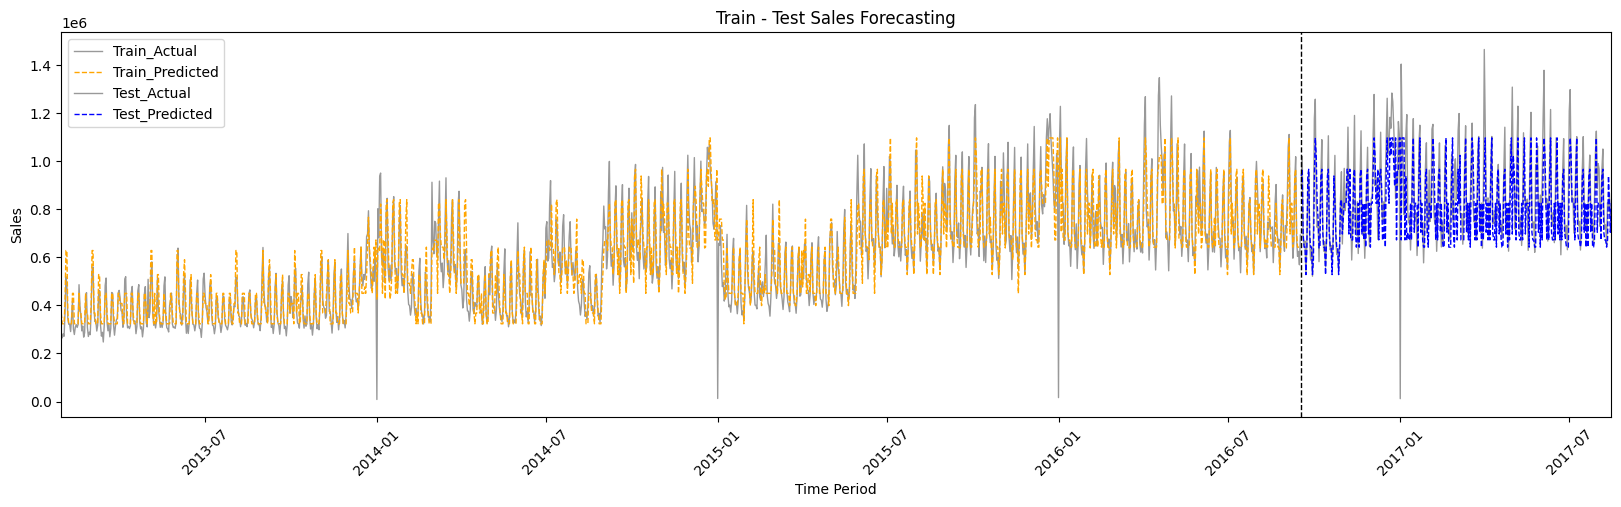

In [894]:
plot(dtr_result, X_test, Y_test)

In [895]:
#Trainset
mad, mse, rmse, mape, rmsle = performance_metrics(dtr_result)
print('MAD=', mad, 'MSE=', mse, 'RMSE=', rmse, 'MAPE=', mape, 'RMSLE=', rmsle)

MAD= 54388.7988246343 MSE= 6567676113.925507 RMSE= 81041.20010171065 MAPE= 20.93462459331828 RMSLE= 0.22321580141433386


In [896]:
#Testset
mad, mse, rmse, mape, rmsle = performance_metrics(Y_test)
print('MAD=', mad, 'MSE=', mse, 'RMSE=', rmse, 'MAPE=', mape, 'RMSLE=', rmsle)

MAD= 111160.94576264847 MSE= 23076851924.42842 RMSE= 151910.67087083915 MAPE= 39.496882232278466 RMSLE= 0.29578128383730945


<a id="section-seven-five"></a>
### 7.5. Extreme Gradient Boosting

In [897]:
def train_extreme_gradient_boosting(X_train, Y_train):
    model = XGBRegressor(n_jobs=-1, max_depth=10, n_estimators=100, learning_rate=0.2)
    model.fit(X_train, Y_train)
    
    result = Y_train.copy()
    
    result['Predicted_Sales'] = model.predict(X_train)
    result['date'] = sales_df['date']
    result['date'].reset_index(drop=True, inplace=True)
       
    print('R-squared:', r2_score(result['sales'], result['Predicted_Sales']))  
    
    # Feature importance visualization
    features = X_train.columns
    importances = model.feature_importances_
    indices = np.argsort(importances)

    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()
    
    return result, model

R-squared: 0.999996391563532


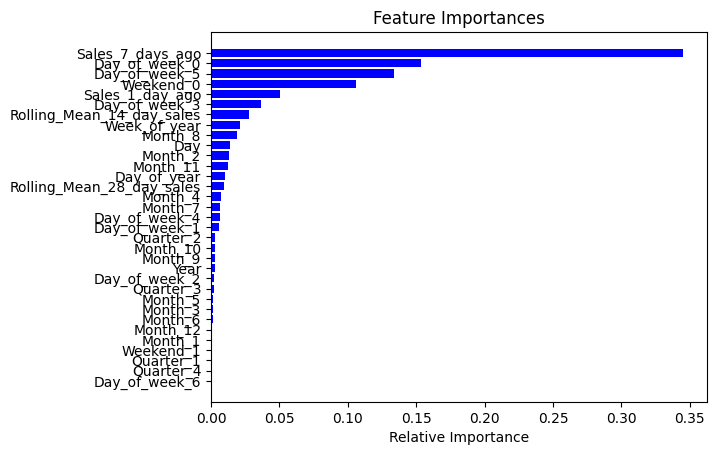

sales  Predicted_Sales       date
27  285460.169953     285444.53125 2013-01-28
28  264488.818077     264461.18750 2013-01-29
29  281061.127052     281008.25000 2013-01-30
30  271254.217996     271265.78125 2013-01-31
31  369402.055266     369521.00000 2013-02-01

In [898]:
xgb_result, model = train_extreme_gradient_boosting(X_train, Y_train)
xgb_result.head()

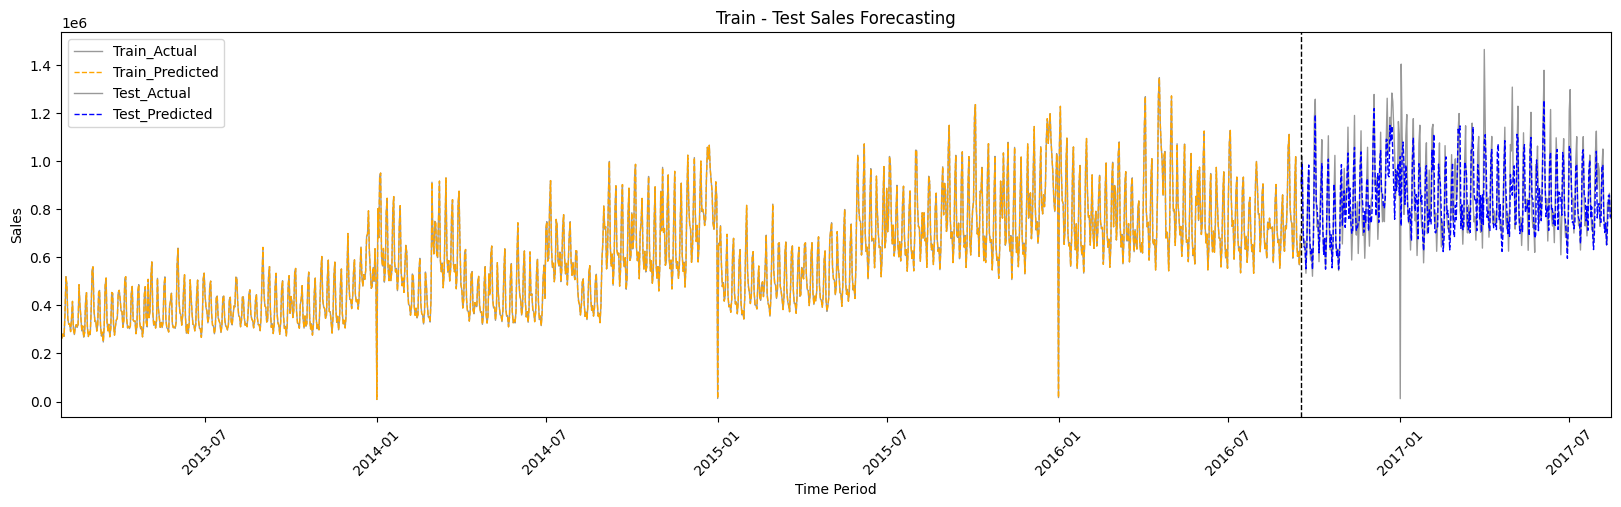

In [899]:
plot(xgb_result, X_test, Y_test)

In [900]:
#Trainset
mad, mse, rmse, mape, rmsle = performance_metrics(xgb_result)
print('MAD=', mad, 'MSE=', mse, 'RMSE=', rmse, 'MAPE=', mape, 'RMSLE=', rmsle)

MAD= 266.93683184832014 MSE= 164301.70459183707 RMSE= 405.3414666572334 MAPE= 0.05540495994299711 RMSLE= 0.0013929334859418207


In [901]:
#Testset
mad, mse, rmse, mape, rmsle = performance_metrics(Y_test)
print('MAD=', mad, 'MSE=', mse, 'RMSE=', rmse, 'MAPE=', mape, 'RMSLE=', rmsle)

MAD= 83387.2834992741 MSE= 15369879521.89432 RMSE= 123975.31819638262 MAPE= 34.36210824937086 RMSLE= 0.27302554121763334


<a id="section-seven-six"></a>
### 7.6. Extremely Randomized Trees

In [902]:
def train_extremely_randomized_trees(X_train, Y_train):
    model = ExtraTreesRegressor(n_jobs=-1, n_estimators=200, min_samples_split=15, min_samples_leaf=4, max_samples=0.95, max_features=4, max_depth=8, bootstrap=True)
    model.fit(X_train, Y_train)
    
    result = Y_train.copy()
    
    result['Predicted_Sales'] = model.predict(X_train)
    result['date'] = sales_df['date']
    result['date'].reset_index(drop=True, inplace=True)
       
    print('R-squared:', r2_score(result['sales'], result['Predicted_Sales']))  
    
    # Feature importance visualization
    features = X_train.columns
    importances = model.feature_importances_
    indices = np.argsort(importances)

    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()
    
    return result, model

c:\Users\Zenbook\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


R-squared: 0.8310731210587794


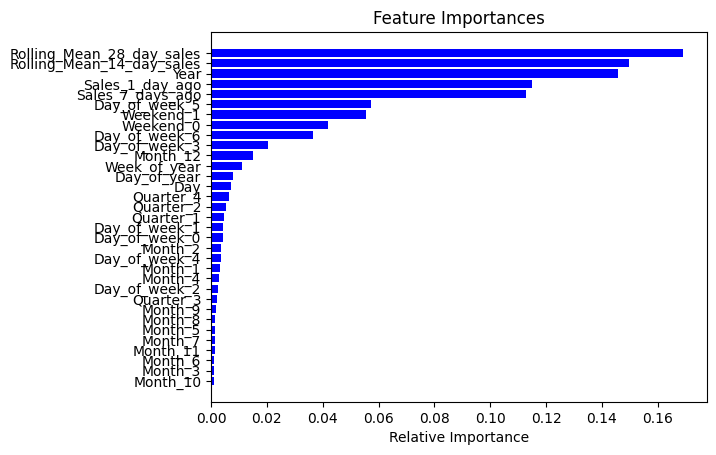

sales  Predicted_Sales       date
27  285460.169953    373165.672179 2013-01-28
28  264488.818077    351525.279967 2013-01-29
29  281061.127052    354030.721189 2013-01-30
30  271254.217996    343089.817945 2013-01-31
31  369402.055266    371751.603519 2013-02-01

In [903]:
etr_result, model = train_extremely_randomized_trees(X_train, Y_train)
etr_result.head()

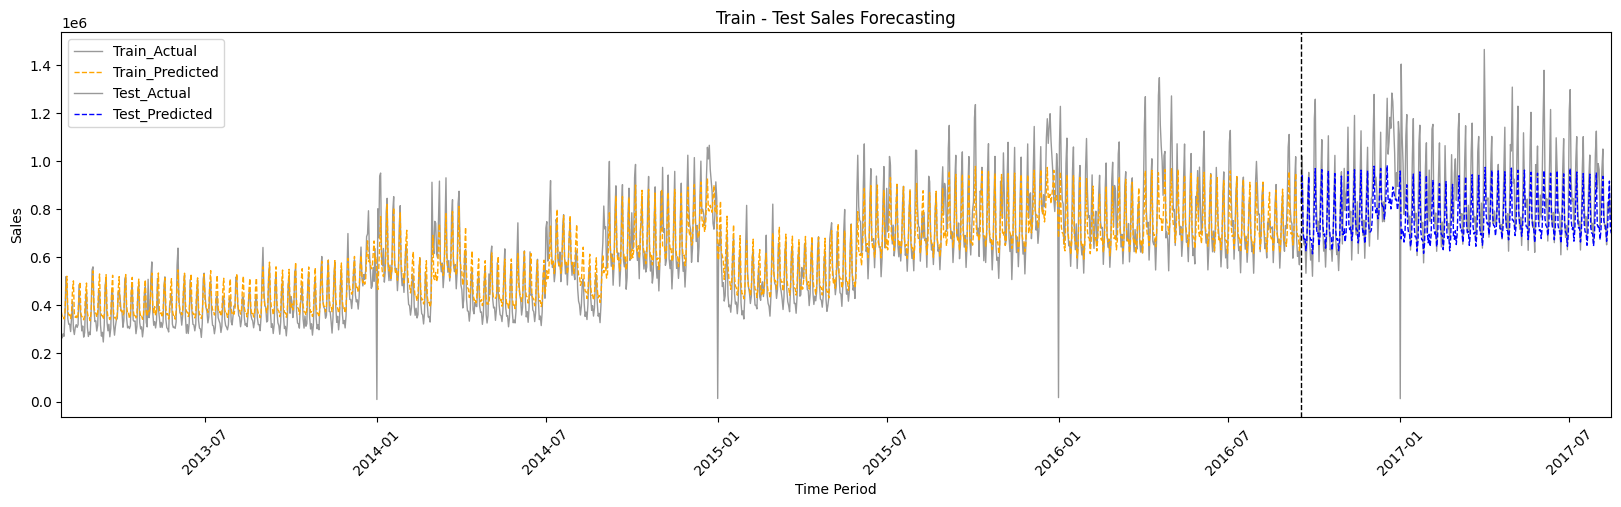

In [904]:
plot(etr_result, X_test, Y_test)

In [905]:
#Trainset
mad, mse, rmse, mape, rmsle = performance_metrics(etr_result)
print('MAD=', mad, 'MSE=', mse, 'RMSE=', rmse, 'MAPE=', mape, 'RMSLE=', rmsle)

MAD= 61592.823570148925 MSE= 7691689851.874727 RMSE= 87702.27962758282 MAPE= 21.461718642877432 RMSLE= 0.22657407189171144


In [906]:
#Testset
mad, mse, rmse, mape, rmsle = performance_metrics(Y_test)
print('MAD=', mad, 'MSE=', mse, 'RMSE=', rmse, 'MAPE=', mape, 'RMSLE=', rmsle)

MAD= 109219.92009032707 MSE= 24385098207.050457 RMSE= 156157.2867561756 MAPE= 34.75801111952161 RMSLE= 0.2874635742237357


<a id="section-seven-seven"></a>
### 7.7. Adaptive Boosting Regression

In [907]:
def train_adaptive_boosting_reg(X_train, Y_train):
    model = AdaBoostRegressor(DecisionTreeRegressor(max_depth=8), n_estimators=100, learning_rate=0.25, loss='square')
    model.fit(X_train, Y_train)
    
    result = Y_train.copy()
    
    result['Predicted_Sales'] = model.predict(X_train)
    result['date'] = sales_df['date']
    result['date'].reset_index(drop=True, inplace=True)
       
    print('R-squared:', r2_score(result['sales'], result['Predicted_Sales']))  
    
    # Feature importance visualization
    features = X_train.columns
    importances = model.feature_importances_
    indices = np.argsort(importances)

    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()
    
    return result, model

c:\Users\Zenbook\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


R-squared: 0.9831127746047574


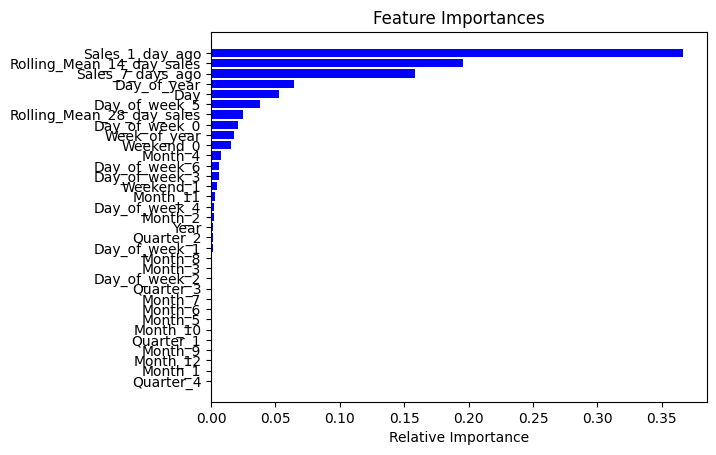

sales  Predicted_Sales       date
27  285460.169953    330089.266210 2013-01-28
28  264488.818077    297966.612014 2013-01-29
29  281061.127052    299698.565175 2013-01-30
30  271254.217996    289403.599492 2013-01-31
31  369402.055266    377894.952701 2013-02-01

In [908]:
ada_result, model = train_adaptive_boosting_reg(X_train, Y_train)
ada_result.head()

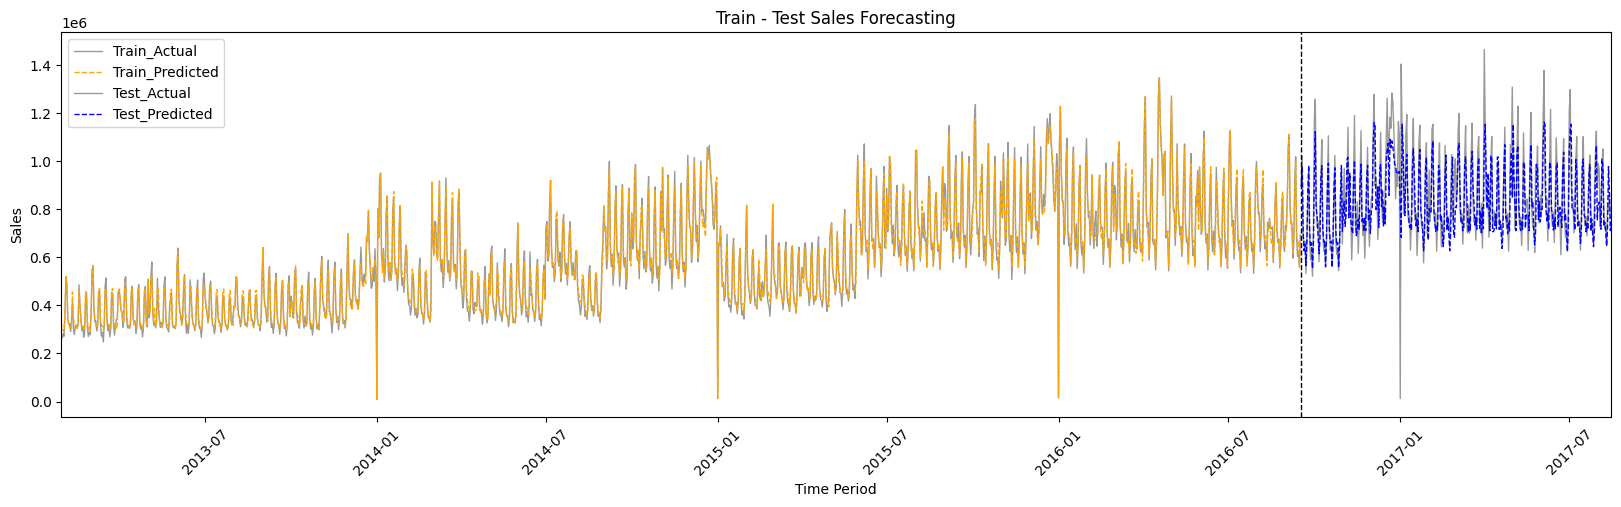

In [909]:
plot(ada_result, X_test, Y_test)

In [910]:
#Trainset
mad, mse, rmse, mape, rmsle = performance_metrics(ada_result)
print('MAD=', mad, 'MSE=', mse, 'RMSE=', rmse, 'MAPE=', mape, 'RMSLE=', rmsle)

MAD= 21029.594879060267 MSE= 768920263.0926813 RMSE= 27729.41151724431 MAPE= 3.8688553821264313 RMSLE= 0.0507585994682639


In [911]:
#Testset
mad, mse, rmse, mape, rmsle = performance_metrics(Y_test)
print('MAD=', mad, 'MSE=', mse, 'RMSE=', rmse, 'MAPE=', mape, 'RMSLE=', rmsle)

MAD= 80433.5038699649 MSE= 13307679570.500233 RMSE= 115358.91630255649 MAPE= 29.02991853608457 RMSLE= 0.25951405589246834


<a id="section-seven-eight"></a>
### 7.8. Outcome Summarizing

![My Image](Screenshot_4.png)

*-> For the train-set, the Extreme Gradient Boosting model performs the best but it seems it did not forecast the same accuracy for test-set. The difference in accuracy between the two data sets is quite large.*

*-> For the test-set, the Adaptive Boosting Regression model performs the best, though it did not perform with the train-set very well*

<a id="section-seven-nine"></a>
### 7.9. K-means Clustering (estimate groups of products with similar seasonality factor)

In [912]:
def product_monthly_sales(df):
    product_df = df.copy()
    product_df.drop(columns= ['id', 'store_nbr', 'onpromotion'], inplace= True)
    product_df.groupby(['family', 'date'], as_index= False).sum()
    product_df['Year'] = stores_df['date'].dt.year
    product_df['Month'] = stores_df['date'].dt.month
    product_df.drop(columns= 'date', inplace = True)
    product_df.rename(columns={ 'sales': 'Monthly_sales'}, inplace=True)
    return product_df

In [913]:
product_df = product_monthly_sales(stores_df)
product_df.head()

family  Monthly_sales  Year  Month
0       AUTOMOTIVE            0.0  2013      1
1194   CELEBRATION            0.0  2013      1
1193  BREAD/BAKERY            0.0  2013      1
1192         BOOKS            0.0  2013      1
1191     BEVERAGES            0.0  2013      1

In [914]:
def monthly_seasonal_factor(df):
    df.groupby(['family', 'Year', 'Month'], as_index= False).sum()
    df['Yearly_avg'] = df.groupby(['family', 'Year'])['Monthly_sales'].transform('mean')
    df = df[df['Yearly_avg'] > 0]
    df['Season_factor'] = df['Monthly_sales']/df['Yearly_avg']
    df.drop(columns= ['Monthly_sales', 'Year', 'Yearly_avg'], inplace = True)
    factor_ed = df.pivot_table(columns='Month', values='Season_factor', index='family')
    return factor_ed

In [915]:
seasonal_factor_df = monthly_seasonal_factor(product_df.copy())
seasonal_factor_df.head()

Month             1         2         3         4         5         6   \
family                                                                   
AUTOMOTIVE  0.907924  1.011929  1.041173  0.985111  0.972262  0.965791   
BABY CARE   0.503605  0.585035  0.888926  0.420868  0.445865  0.871259   
BEAUTY      0.907610  0.905032  0.880391  0.871188  0.902891  0.928601   
BEVERAGES   0.940913  0.799706  0.956265  0.863327  0.879930  0.942469   
BOOKS       1.222009  0.942807  0.745204  0.420914  0.239981  0.097887   

Month             7         8         9         10        11        12  
family                                                                  
AUTOMOTIVE  1.012823  1.002340  0.922679  1.028293  1.021602  1.156143  
BABY CARE   1.802734  1.327980  2.378128  0.836491  0.398091  1.958449  
BEAUTY      1.040879  1.105465  1.036202  1.100251  1.168640  1.277717  
BEVERAGES   1.038442  0.930441  1.165998  1.130369  1.182879  1.313330  
BOOKS       0.072626  0.017024  0.000000  5.096719  3.866513  3.033544

In [916]:
#scaler
from sklearn.preprocessing import StandardScaler
def scaler(df):
    scaler = StandardScaler()
    scaled_df = scaler.fit_transform(df)
    scaled_df = pd.DataFrame(scaled_df, index=df.index, columns=df.columns)
    return scaled_df

In [917]:
scaled_df = scaler(seasonal_factor_df)
scaled_df.head()

Month             1         2         3         4         5         6   \
family                                                                   
AUTOMOTIVE  0.049921  0.896345  0.791225  0.770264  0.562781  0.461447   
BABY CARE  -2.498134 -0.898559 -0.389470 -1.908523 -1.708295 -0.012365   
BEAUTY      0.047940  0.446889 -0.455663  0.229404  0.263491  0.275042   
BEVERAGES   0.257820  0.004039  0.132749  0.192083  0.164427  0.344553   
BOOKS       2.029311  0.605714 -1.504049 -1.908305 -2.596557 -3.888665   

Month             7         8         9         10        11        12  
family                                                                  
AUTOMOTIVE  0.001432  0.089811 -0.405362 -0.279937 -0.303500 -0.584387  
BABY CARE   2.902125  0.907853  1.538625 -0.543919 -1.461740  0.677658  
BEAUTY      0.104460  0.348871 -0.253734 -0.180900 -0.030360 -0.393149  
BEVERAGES   0.095509 -0.090809 -0.080370 -0.139448 -0.003909 -0.337127  
BOOKS      -3.451137 -2.385412 -1.637748  5.319533  4.981239  2.368804

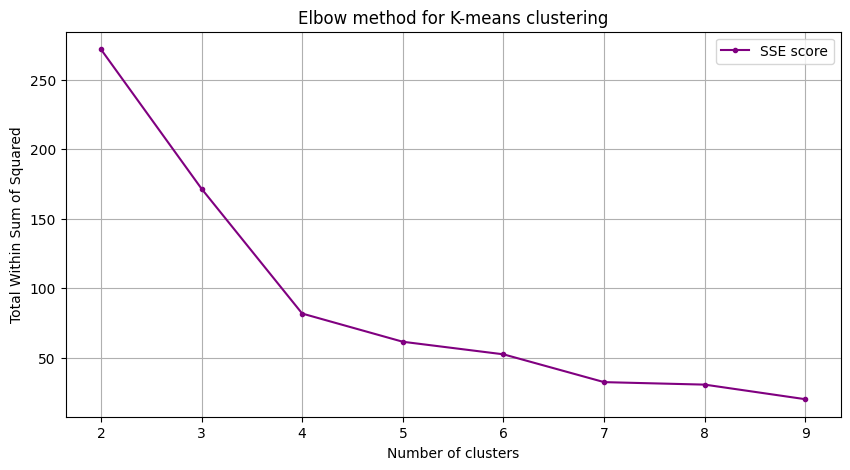

In [ ]:
#Elbow methodology
data = scaled_df
sse = {}

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center


plt.figure(figsize=(10, 5))

plt.plot(list(sse.keys()), list(sse.values()),
         marker= '.',
         c= 'purple')
plt.legend(['SSE score'])
plt.grid(True)
plt.title('Elbow method for K-means clustering')
plt.xlabel("Number of clusters")
plt.ylabel("Total Within Sum of Squared")
plt.show()

In [ ]:
#kmeans with k = 4
kmeans = KMeans(n_clusters=4, random_state=42, max_iter=1000)
kmeans.fit(scaled_df)

KMeans(max_iter=1000, n_clusters=4, random_state=42)

<Axes: ylabel='Month'>

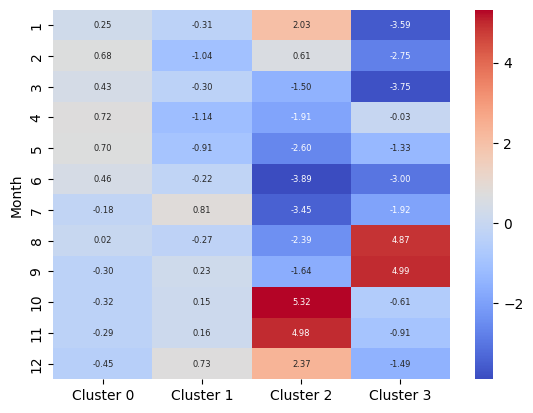

In [920]:
centers = pd.DataFrame(data=kmeans.cluster_centers_).transpose()
centers.index = scaled_df.columns
centers.columns = [f'Cluster {x}' for x in range(centers.shape[1])]
sns.heatmap(centers,annot=True, cmap='coolwarm', fmt=".2f", annot_kws={'size': 6})

In [921]:
scaled_df['Cluster'] = kmeans.predict(scaled_df)
print('Number of products per cluster: \n',scaled_df['Cluster'].value_counts().sort_index())

Number of products per cluster: 
 Cluster
0    20
1    11
2     1
3     1
Name: count, dtype: int64


In [922]:
scaled_df.reset_index(inplace= True)
print('Two products with seasonal factor are: \n', scaled_df.loc[scaled_df['Cluster'].isin([2, 3]), ['family']])

Two products with seasonal factor are: 
 Month                      family
4                           BOOKS
31     SCHOOL AND OFFICE SUPPLIES


*-> It seems that almost all products are not affected by the seasonality factor (20 products of cluster 0 and 11 products of cluster 1), and only 2 of 33 products in total have a strong effect by the seasonality factor (belongs to cluster 2 and 3)*

<a id="section-eight"></a>
## 8. Multi-Product Forecasting with a Local Model

In [923]:
stores_df.drop(columns = ['id', 'onpromotion', 'store_nbr'], inplace= True)
stores_df = stores_df.groupby(['date', 'family'], as_index= False).sum()
stores_df.head()

date      family  sales
0 2013-01-01  AUTOMOTIVE    0.0
1 2013-01-01   BABY CARE    0.0
2 2013-01-01      BEAUTY    2.0
3 2013-01-01   BEVERAGES  810.0
4 2013-01-01       BOOKS    0.0

In [924]:
def decompose_date_sales_for_item(df, item, date, quantity):
    # Time paterns
    df['Month'] = df[date].dt.month
    df['Year'] = df[date].dt.year  
    df['Day'] = df[date].dt.day
    df['Day_of_week'] = df[date].dt.weekday
    df['Week_of_year'] = pd.to_datetime(sales_df[date]).dt.strftime('%U').astype('int32')
    df['Day_of_year'] = df[date].dt.dayofyear
    df['Weekend'] = df['Day_of_week'].apply(lambda x: 1 if x > 5 else 0)
    df['Quarter'] = df[date].dt.quarter
    # Sales paterns
    df['Sales_1_day_ago'] = df.groupby(item)[quantity].shift(1)
    df['Sales_7_days_ago'] = df.groupby(item)[quantity].shift(7)
    df['Rolling_Mean_14_day_sales'] = df.groupby(item)[quantity].rolling(window=14).mean().reset_index(drop=True)
    df['Rolling_Mean_28_day_sales'] = df.groupby(item)[quantity].rolling(window=28).mean().reset_index(drop=True)
    return df

In [925]:
stores_df = decompose_date_sales_for_item(stores_df, 'family','date', 'sales')
for feature in features:
    stores_df = encode_and_bind(stores_df, feature)

stores_df.dropna(axis= 1, inplace= True)
stores_df.head()

date      family  sales  Year  Day  Day_of_year  Weekend_0  Weekend_1  \
0 2013-01-01  AUTOMOTIVE    0.0  2013    1            1          1          0   
1 2013-01-01   BABY CARE    0.0  2013    1            1          1          0   
2 2013-01-01      BEAUTY    2.0  2013    1            1          1          0   
3 2013-01-01   BEVERAGES  810.0  2013    1            1          1          0   
4 2013-01-01       BOOKS    0.0  2013    1            1          1          0   

   Month_1  Month_2  ...  Quarter_2  Quarter_3  Quarter_4  Day_of_week_0  \
0        1        0  ...          0          0          0              0   
1        1        0  ...          0          0          0              0   
2        1        0  ...          0          0          0              0   
3        1        0  ...          0          0          0              0   
4        1        0  ...          0          0          0              0   

   Day_of_week_1  Day_of_week_2  Day_of_week_3  Day_of_week_4  Day_of_week_5  \
0              1              0              0              0              0   
1              1              0              0              0              0   
2              1              0              0              0              0   
3              1              0              0              0              0   
4              1              0              0              0              0   

   Day_of_week_6  
0              0  
1              0  
2              0  
3              0  
4              0  

[5 rows x 31 columns]

In [926]:
def train_xgb_local_model(df):
    products = df['family'].unique()
    RMSE = {}
    MAPE = {}

    for product in products:
            df_filtered = df[df['family'] == product]

            X = df_filtered.drop(columns=['date', 'family', 'sales'])
            Y = df_filtered[['sales']]

            xgb_model = XGBRegressor(n_jobs=-1, max_depth=10, n_estimators=100, learning_rate=0.2)
            xgb_model.fit(X, Y)
            
            Y = Y.copy()
            Y['Predicted'] = xgb_model.predict(X)

            rmse_value = round(np.sqrt(np.mean((Y['sales'] - Y['Predicted'])**2)), 2)
            mape_value = round(mean_absolute_percentage_error(Y['sales'], Y['Predicted'])*100, 2)
            RMSE[product] = rmse_value  
            MAPE[product] = mape_value

    df['RMSE'] = df['family'].map(RMSE)
    df['MAPE_(%)'] = df['family'].map(MAPE)
    
    df = df[['family', 'RMSE', 'MAPE_(%)']].groupby('family', as_index= False).first()
                                                                       
    return df

In [927]:
product_metrics_df = train_xgb_local_model(stores_df.copy())
product_metrics_df

family    RMSE      MAPE_(%)
0                   AUTOMOTIVE    2.43  6.191560e+13
1                    BABY CARE    0.08  3.788971e+15
2                       BEAUTY    1.04  4.700000e-01
3                    BEVERAGES  335.03  2.300000e-01
4                        BOOKS    0.01  5.313860e+14
5                 BREAD/BAKERY   59.35  1.800000e-01
6                  CELEBRATION    4.14  1.738694e+17
7                     CLEANING  147.57  1.900000e-01
8                        DAIRY  119.22  2.400000e-01
9                         DELI   34.94  2.000000e-01
10                        EGGS   34.47  2.800000e-01
11                FROZEN FOODS   33.28  3.800000e-01
12                   GROCERY I  470.63  2.000000e-01
13                  GROCERY II    7.86  5.200000e-01
14                    HARDWARE    0.71  2.499083e+13
15          HOME AND KITCHEN I   11.03  3.994872e+17
16         HOME AND KITCHEN II    5.83  1.089405e+17
17             HOME APPLIANCES    0.31  1.885556e+15
18                   HOME CARE   36.82  1.885561e+18
19                  LADIESWEAR    2.68  1.567804e+17
20             LAWN AND GARDEN    3.17  1.050000e+00
21                    LINGERIE    2.37  4.800000e-01
22            LIQUOR,WINE,BEER   57.18  1.038771e+18
23                   MAGAZINES    0.85  2.975221e+16
24                       MEATS   68.50  2.700000e-01
25               PERSONAL CARE   38.66  2.700000e-01
26                PET SUPPLIES    0.96  4.240682e+16
27     PLAYERS AND ELECTRONICS    1.83  9.363663e+16
28                     POULTRY   57.08  2.800000e-01
29              PREPARED FOODS   15.43  2.400000e-01
30                     PRODUCE  195.01  8.605458e+17
31  SCHOOL AND OFFICE SUPPLIES    1.08  5.984361e+16
32                     SEAFOOD    5.13  7.426111e+13

In [928]:
print('Average Outcome Accuracy:', 'RMSE', product_metrics_df['RMSE'].mean().round(2), ', MAPE', product_metrics_df['MAPE_(%)'].mean().round(2), '%')

Average Outcome Accuracy: RMSE 53.17 , MAPE 1.4715035076760317e+17 %


**References:**  

*https://medium.com/@humzahmalik/demand-forecasting-for-multi-product-datasets-time-series-analysis-c501d432f553*

*https://towardsdatascience.com/machine-learning-for-store-demand-forecasting-and-inventory-optimization-part-1-xgboost-vs-9952d8303b48/*